# Correlated multi-variate Poisson distributed variables

## Introduction

In this notebook, a simplistic approach to generating correlated Poisson-distributed random variables is explored along with a method for inferring the parameters using JAGS.

In [12]:
# Import the required libraries
library(dplyr)
library(ggplot2)
library(MCMCvis)
library(rjags)

# Ensure the figures are easy to view in the notebook
options(repr.plot.width=8, repr.plot.height=4)

## Data generation

In [94]:
# Mean of the Poisson distribution in common
lambda0 = 6

# Means of the Poisson distributions
lambda1 = 3
lambda2 = 4

# Number of samples
N = 100

Y0 = rpois(N, lambda0)
Y1 = rpois(N, lambda1)
Y2 = rpois(N, lambda2)

X1 = Y0 + Y1
X2 = Y0 + Y2

In [95]:
# Measure the correlation between the samples
cor(X1, X2)

[1] 0.6263196

In [1]:
# Plot the samples as a timeseries
df = data.frame(i=1:N, X1, X2)

ggplot(df) + 
    geom_point(aes(x=i, y=X1), size=1, color="blue", alpha=0.4) +
    geom_line(aes(x=i, y=X1), size=0.2, color="blue", alpha=0.4, linetype=2) +
    geom_point(aes(x=i, y=X2), size=1, color="red", alpha=0.4) +
    geom_line(aes(x=i, y=X2), size=0.2, color="red", alpha=0.4, linetype=2) +
    xlab("Index") +
    ylab("Sample value") +
    ggtitle(paste0("Poisson distributed samples (correlation coefficient = ", round(cor(X1, X2), 3), ")"))

ERROR: Error in data.frame(i = 1:N, X1, X2): object 'N' not found


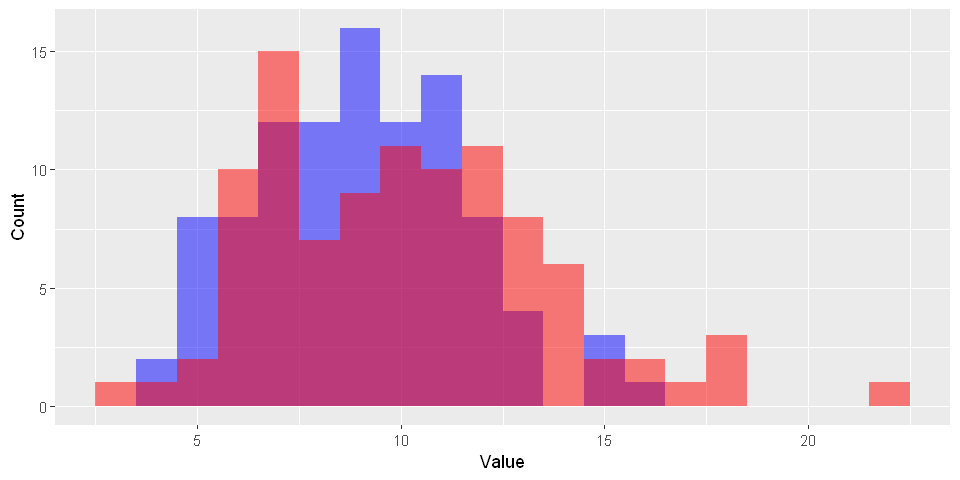

In [97]:
# Plot histograms of the samples
ggplot(df) +
    geom_histogram(aes(x=X1), binwidth=1, fill="blue", alpha=0.5) +
    geom_histogram(aes(x=X2), binwidth=1, fill="red", alpha=0.5) +
    xlab("Value") + 
    ylab("Count")

## Parameter inference

In [98]:
# Find the means of the Poisson variables
cat("Mean of X1 =", mean(X1), "\n")
cat("Mean of X2 =", mean(X2))

Mean of X1 = 9.03 
Mean of X2 = 10.14

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 204

Initializing model



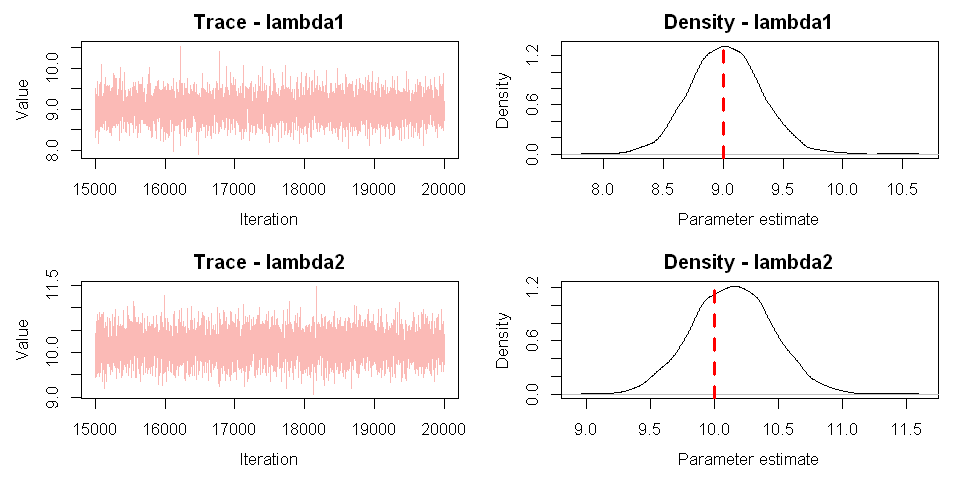

In [99]:
# Infer the parameters of the Poisson variables (ignoring the correlation part)
model_string = "
model {

    # Priors
    lambda1 ~ dexp(0.1)
    lambda2 ~ dexp(0.1)

    # Likelihood
    for (i in 1:N) {
        y1[i] ~ dpois(lambda1)
        y2[i] ~ dpois(lambda2)
    }
}
"

model = jags.model(textConnection(model_string),
                   data = list(N=length(X1), y1=X1, y2=X2))

update(model, 
       10000, 
       progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("lambda1", "lambda2"), 
                     n.iter=20000, progress.bar="none")

gv = c(lambda0 + lambda1, lambda0 + lambda2)
MCMCtrace(samp, 
          params=c("lambda1", "lambda2"),
          gv=gv,
          pdf=FALSE)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 3
   Total graph size: 207

Initializing model



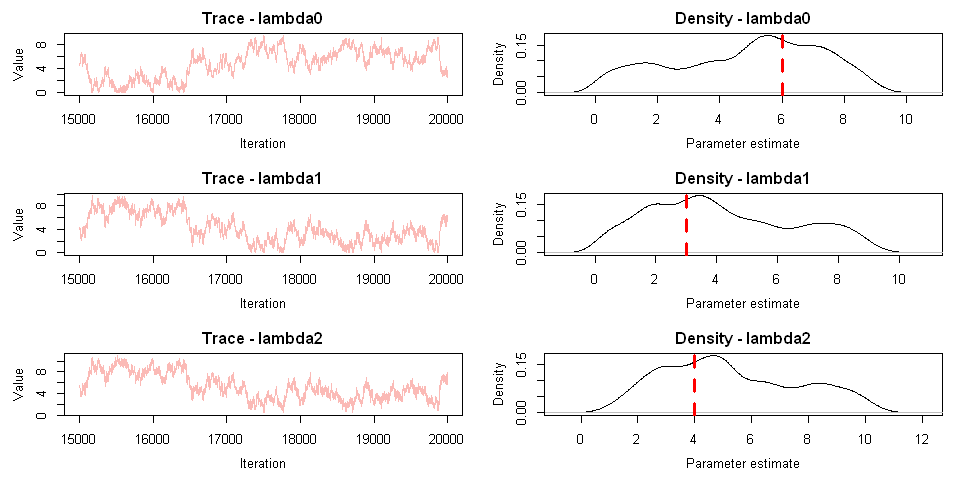

In [100]:
# Infer the parameters of correlated Poisson variables.
model_string = "
model {

    # Priors
    lambda0 ~ dexp(0.1)  # common to both variables
    lambda1 ~ dexp(0.1)
    lambda2 ~ dexp(0.1)

    # Likelihood
    for (i in 1:N) {
        y1[i] ~ dpois(lambda0 + lambda1)
        y2[i] ~ dpois(lambda0 + lambda2)
    }
}
"

model = jags.model(textConnection(model_string),
                   data = list(N=length(X1), y1=X1, y2=X2))

update(model, 
       10000, 
       progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("lambda0", "lambda1", "lambda2"), 
                     n.iter=20000, 
                     progress.bar="none")

gv = c(lambda0, lambda1, lambda2)
MCMCtrace(samp, 
          params=c("lambda0", "lambda1", "lambda2"),
          gv=gv,
          pdf=FALSE)

There may be too many unconstrained degrees of freedom for the model above to converge correctly to produce narrower posterior distributions.